In [31]:
# Importing necessary libraries
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Libraries for TensorFlow
from tensorflow.keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow import keras

# Library for Transfer Learning
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
# Setting the image size for resizing
image_size = 32


def read_image(class_path, image_file):
    image_path = os.path.join(class_path, image_file)
    image =  cv2.imread(image_path)
    image = cv2.resize(image, (image_size, image_size))
    return image


# Creating empty lists to store class labels and images
class_labels_list = []
images_list = []

# Path to the dataset directory
data_directory = './dataset/Validation/'

# List of class directories in the dataset
# directories = os.listdir(data_directory)
directories = ['A','B','C','D','E','F','G']


# Loop through each class directory
for class_label, class_name in enumerate(directories):
    class_path = os.path.join(data_directory, class_name)
    
    # Loop through each image file in the class directory
    for image_file in os.listdir(class_path):
        # Check if the file is a JPEG image
        if image_file.endswith('.jpg'):
            # Read and preprocess the image
            image = read_image(class_path, image_file)
            
            # Append the image and its corresponding class label to the lists
            images_list.append(image)
            class_labels_list.append(class_label)

# Separate data into feature vectors (X) and class labels (y)

data_x = images_list
data_y = class_labels_list


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, 
                                                    test_size=0.25, 
                                                    random_state=13)


In [32]:
# Augmentation
datagen = ImageDataGenerator(
    rescale=1./255.,
    zoom_range=0.1,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Generate augmented data using the generator
aug_train_data = datagen.flow(
    np.array(X_train), np.array(y_train), batch_size=32, shuffle=True
)

# Retrieve augmented images and labels from the generator
generated_images, generated_labels = aug_train_data.next()

# Print the shape of the generated images and labels
print(f'Shape of generated images: {generated_images.shape}')
print(f'Shape of generated labels: {generated_labels.shape}')

# Concatenate the data
concatenated_data = np.concatenate((X_train, generated_images), axis=0)

# Concatenate the labels of the original data and augmented data
original_labels = y_train
concatenated_labels = np.concatenate((original_labels, generated_labels), axis=0)

x_train_flatten, x_test_flatten, y_train_flatten, y_test_flatten = train_test_split(
    concatenated_data, concatenated_labels, test_size=0.2, random_state=42
)

print(concatenated_data.shape)
print(concatenated_labels.shape)



Shape of generated images: (32, 32, 32, 3)
Shape of generated labels: (32,)
(1728, 32, 32, 3)
(1728,)


In [33]:

#define VGG16 Model
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (image_size, image_size, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False #change to true and comment the difference

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

# model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(512, activation='relu'))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(128, activation='relu'))



model_vgg16.add(tf.keras.layers.Dense(85, activation='relu'))
model_vgg16.add(tf.keras.layers.Dense(65, activation='relu'))
model_vgg16.add(tf.keras.layers.Dense(45, activation='relu'))
model_vgg16.add(tf.keras.layers.Dense(39, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['acc'])
model_vgg16.summary()
model_vgg16.save("model.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

c:\Users\ma407\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
from keras.callbacks import EarlyStopping
checkpoint = tf.keras.callbacks.ModelCheckpoint(
             filepath='./model.h5',
             monitor='val_accuracy',
             mode='max',
            save_best_only=True,
            verbose=1)
early =EarlyStopping(monitor='val_loss', mode='max',restore_best_weights=True, verbose=1, patience=1)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        concatenated_data,
        concatenated_labels,
        validation_data = (np.array(X_test), np.array(y_test)),
        epochs=10,
        batch_size=32,
        verbose=1,
        callbacks=callbacks_list
)

Epoch 1/10
54/54 [==============================] - ETA: 0s - loss: 4.2136 - acc: 0.0023

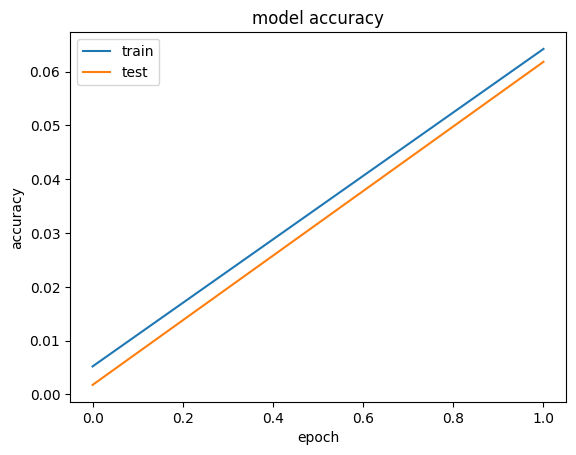

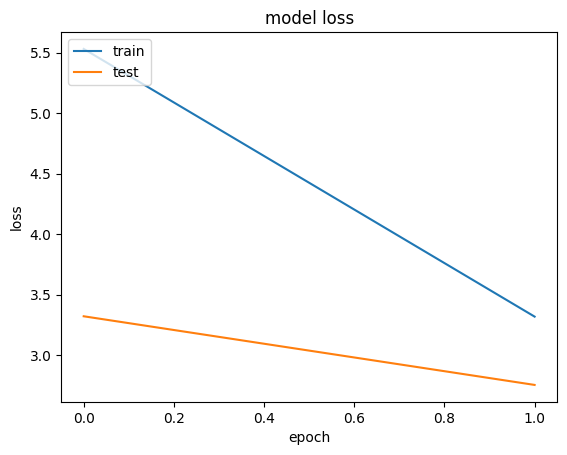

In [ ]:
# plot learning curve
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Define ResNet-50 model
tf.keras.backend.clear_session()
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

# Freeze the layers of the base model
base_model.trainable = False

# Add your classification head
model_resnet = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(85, activation='relu'),
    tf.keras.layers.Dense(65, activation='relu'),
    tf.keras.layers.Dense(45, activation='relu'),
    tf.keras.layers.Dense(39, activation='softmax')
])

# Compile the model
model_resnet.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0001),
                     metrics=['acc'])
# Save the model
model_resnet.save("resnet_model.h5")

c:\Users\ma407\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.callbacks import EarlyStopping
checkpoint = tf.keras.callbacks.ModelCheckpoint(
             filepath='./resnet_model.h5',
             monitor='val_accuracy',
             mode='max',
            save_best_only=True,
            verbose=1)
early =EarlyStopping(monitor='val_loss', mode='max',restore_best_weights=True, verbose=1, patience=1)

callbacks_list = [checkpoint,early]

history_2 = model_resnet.fit(
        concatenated_data,
        concatenated_labels,
        validation_data = (np.array(X_test), np.array(y_test)),
        epochs=10,
        batch_size=32,
        verbose=1,
        callbacks=callbacks_list
)


Epoch 1/10
54/54 [==============================] - 7s 125ms/step - loss: 2.3904 - acc: 0.1765 - val_loss: 1.7018 - val_acc: 0.0689
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 1.6963 - acc: 0.1840WARNING:tensorflow:Can save best model only with val_accuracy available, skipping.
Restoring model weights from the end of the best epoch: 1.
54/54 [==============================] - 7s 125ms/step - loss: 1.6963 - acc: 0.1840 - val_loss: 1.2241 - val_acc: 0.2085
Epoch 2: early stopping


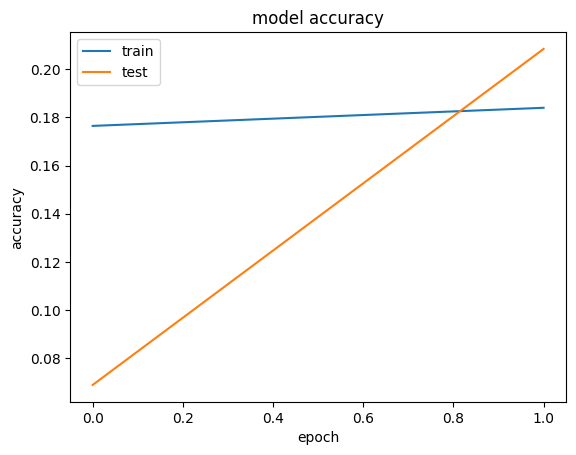

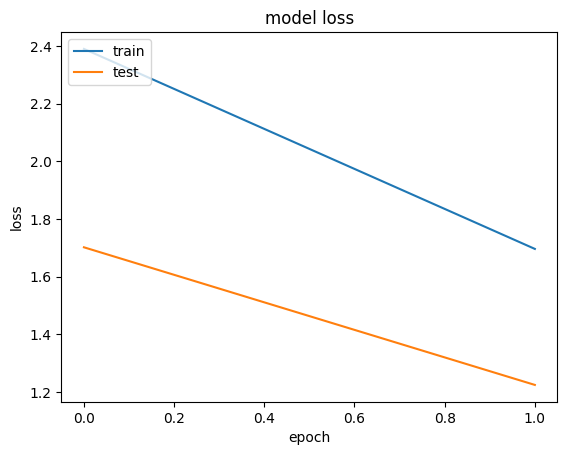

In [ ]:
# plot learning curve
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Access the ResNet50 model within your Sequential model
resnet_model = model_resnet.get_layer("resnet50")

# Print the summary of the ResNet50 model to find the last conv layer name
print(resnet_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

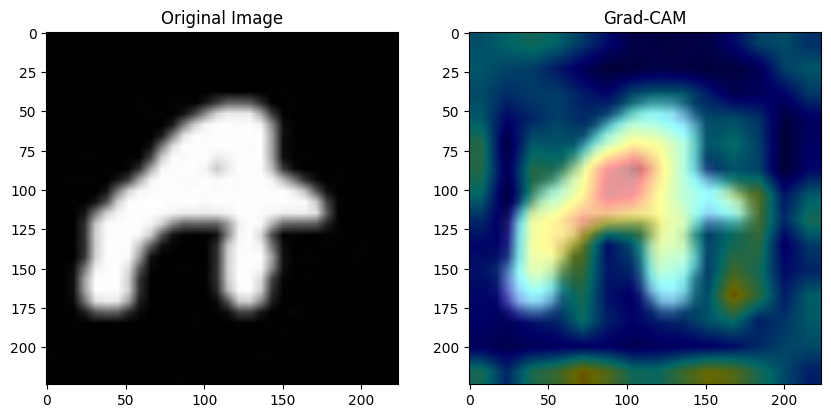

In [ ]:
# Function to generate Grad-CAM heatmap
def generate_grad_cam(model, img_array, class_idx, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = cv2.resize(cam, (img_array.shape[1], img_array.shape[2]))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    return cam

# Load your pre-trained VGG16 model
model_vgg16 = tf.keras.applications.VGG16(weights='imagenet')

# Get the class index you want to visualize
class_index_to_visualize = 0  # Replace this with the index of the class you want to visualize

# Prepare an image for visualization (Replace this with your image preprocessing)
# For example, read and preprocess an image
image_size = (224, 224)  # VGG16 expects an input size of 224x224
img_path = './dataset/Validation/A/0.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, image_size)
img_array = np.expand_dims(img, axis=0)  # Reshape the image for the model input

# Get the last convolutional layer name in your model
last_conv_layer_name = 'block5_conv3'   # Replace this with the name of your last convolutional layer in VGG16

# Generate Grad-CAM heatmap
heatmap = generate_grad_cam(model_vgg16, img_array, class_index_to_visualize, last_conv_layer_name)

# Apply heatmap on the original image
heatmap = cv2.resize(heatmap, image_size)
heatmap = heatmap / heatmap.max()
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Visualize the original image and Grad-CAM result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM')
plt.show()